<h1><center>«Portfolio-Exam Part II» </center></h1>
<h2><center>MADS-MMS </center></h2>
<h3><center>Author: Tom Wüsten </center></h3>

### Abstract
This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. <br>



### Information about the Dataset
Attribute Information: <br>

InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. <br>
StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. <br>
Description: Product (item) name. Nominal. <br>
Quantity: The quantities of each product (item) per transaction. Numeric. <br>
InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. <br>
UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). <br>
CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. <br>
Country: Country name. Nominal. The name of the country where a customer resides. <br>


### Outline
* [Data Cleansing](#1) <br>
* [Data Exploration](#2) <br>
* [Data Preparation](#3) <br>
* [Partitioning Clustering with K-means](#4) <br>
* [Hierarchical CLustering](#5) <br>
* [Fuzzy Clustering](#6) <br>
* [Evaluation](#6) <br>

In [383]:
#Load Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from imp import reload
from sklearn.cluster import DBSCAN
from functools import reduce
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from scipy.stats import pearsonr
from fcmeans import FCM

### Data Cleansing <a id='1'></a> 
Looking for missing values, remove duplicates

In [384]:
# Import Dataset
df1 = pd.read_excel('online_retail_II.xlsx', sheet_name = 0)
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name = 1)
df = pd.concat([df1,df2], axis=0)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [385]:
print(df.shape)
df.drop_duplicates()
print(df.shape)

(1067371, 8)
(1067371, 8)


In [386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [387]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [388]:
df.shape

(1067371, 8)

In the following, the data set is examined for missing values. It can be seen that there are missing values for the Description and Customer ID features. <br>
For the feature Description, 0.41% of the values are missing. This is to be considered very low and, in my view, can be seen as a missing entry in the product database. <br>
For the Customer ID feature, 22.7% of all invoices do not have a customer ID. This leads to booking errors because no customer can be assigned to the invoice. <br>
For further consideration of the data, the data must be removed.

In [389]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

In [390]:
customerID = df["Customer ID"].isnull()
customerID_ = df[customerID]
customerID_.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [391]:
quantity = df['Quantity'] < 0
quantity_ = df[quantity]
quantity_

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


When examining the item price, it is noticeable that certain items do not have a commodity price. <br> 
These calculations can lead to erroneous assumptions in further use. For this purpose, all invoices that have a price of 0 Sterling per item are removed.

In [392]:
price = df['Price'] == 0
price_ = df[price]
price_.head()
print(price_.shape)
price_1 = price_["StockCode"].unique()
price_1
check = df[df["StockCode"].isin(price_1)]["Price"] == 0
check.value_counts()

(6202, 8)


False    599316
True       6202
Name: Price, dtype: int64

In [393]:
price = df['Price'] != 0
price_ = df[price]
print(price_.head())
df_null_price = round(100*(price_.isnull().sum())/len(price_), 2)
print(df_null_price)
df.dropna(inplace = True)

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
Invoice         0.00
StockCode       0.00
Description     0.00
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.32
Country         0.00
dtype: float64


In [394]:
df.shape

(824364, 8)

## Data Exploration <a id='2'></a> 

In the data exploration I want to discover:
* [Time of product purchase](#10) <br>
* [Sales by country](#11) <br>
* [Return rate of the products](#12) <br>
* [Product Analysis](#13) <br>
* [Customer Analysis](#14) <br>




### Time of product purchase <a id='10'></a> 
In order to create an analysis of the point of purchase, additional information must be obtained from the feature InvoiceDate. <br>
The year, month, day of the week and hour are used for further analysis. In the following, we will examine how the online shop has developed over the years 2009-2011. <br> 
The number of orders is used for this purpose. Furthermore, we want to find out in which month, on which day of the week and in which hours most orders are placed.	

In [395]:
# Get extra Features out of the InvoiceDate
df['year'] = df['InvoiceDate'].dt.year
df['month'] = df['InvoiceDate'].dt.strftime("%b")
df['weekday'] = df['InvoiceDate'].dt.strftime("%a")
df['hour'] = df['InvoiceDate'].dt.hour
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,year,month,weekday,hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,Dec,Tue,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,Dec,Tue,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,Dec,Tue,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,Dec,Tue,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,Dec,Tue,7


The plot "Distribution of invoices per year" shows the number of bills over the years 2009-2011. It can be seen that there was a strong increase in business in 2010.<br>
Furthermore, business remained similarly high in 2011. <br>
The plot "Distribution of invoices per month" shows the number of bills over the months. <br>
The plot shows that orders start to increase in September and reach a peak in November. <br>
Since it is an online shop, I would interpret this to mean that it is the Christmas business. <br>
In the remaining months from January to August, business is at the same level.

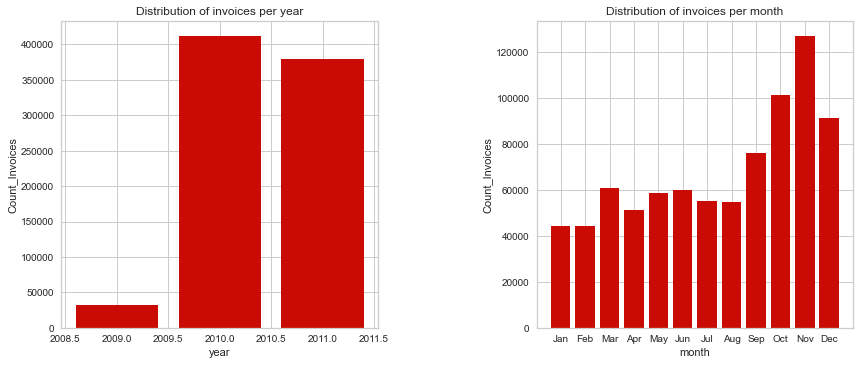

In [396]:
year = df.groupby("year", as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=0.9, wspace=0.5, hspace=None)
ax[0].bar(year["year"], year["Count_Invoices"], color='r')
# Bar Plot
ax[0].set_ylabel('Count_Invoices')
ax[0].set_xlabel('year')
ax[0].set_title('Distribution of invoices per year')
# 2. Plot
month = df.groupby([df['InvoiceDate'].dt.strftime('%m'),'month'], as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
ax[1].bar(month["month"], month["Count_Invoices"], color='r')
# Bar Plot
ax[1].set_ylabel('Count_Invoices')
ax[1].set_xlabel('month')
ax[1].set_title('Distribution of invoices per month')
# Show Plot
plt.show()

The plot "Distribution of invoices per weekday" shows the number of bills over the weekdays. <br>
A peak in orders can be seen on Thursday. A constant level of incoming goods can be seen on Monday, Tuesday, Wednesday and Sunday. <br>
On Friday, a decrease of 20% in purchases can be seen. But the most interesting thing is that there are no orders on Saturday. <br>
This seems very unusual and one would have to ask the person responsible for the data why there is no data or no orders on Saturday. <br>
The plot "Distribution of invoices per hour" shows the number of bills over the hours. <br>
The plot behaves like a gaussian distribution. With the assumption that most customers are wholesalers,  can assume that most purchases are made during business hours.

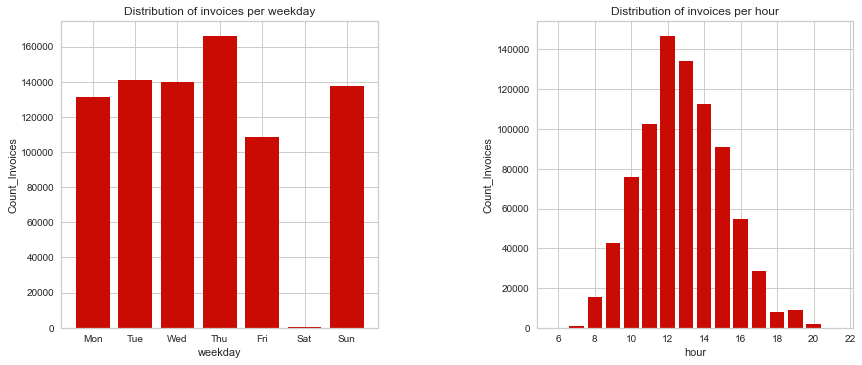

In [397]:
weekday = df.groupby([df['InvoiceDate'].dt.weekday,"weekday"], as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=0.9, wspace=0.5, hspace=None)
ax[0].bar(weekday["weekday"], weekday["Count_Invoices"], color='r')
# Bar Plot
ax[0].set_ylabel('Count_Invoices')
ax[0].set_xlabel('weekday')
ax[0].set_title('Distribution of invoices per weekday')
# Second Plot
hour = df.groupby("hour", as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
ax[1].bar(hour["hour"], hour["Count_Invoices"], color='r')
# Bar Plot
ax[1].set_ylabel('Count_Invoices')
ax[1].set_xlabel('hour')
ax[1].set_title('Distribution of invoices per hour')
# Show Plot
plt.show() 

### Sales by country <a id='11'></a> 
To measure sales by country, the sales volume per order must first be determined. To do this, the features Quantity and Price are multiplied. This result is in the new feature Cost per Invoice. <br>
The most turnover is made in the UK with 82.93%. The online shop also has small turnovers in EIRE (Irland), Netherland, <br> Germany and France. This countries come to a turnover of 11,21%. The rest 6% of the turnover is made around the world. 

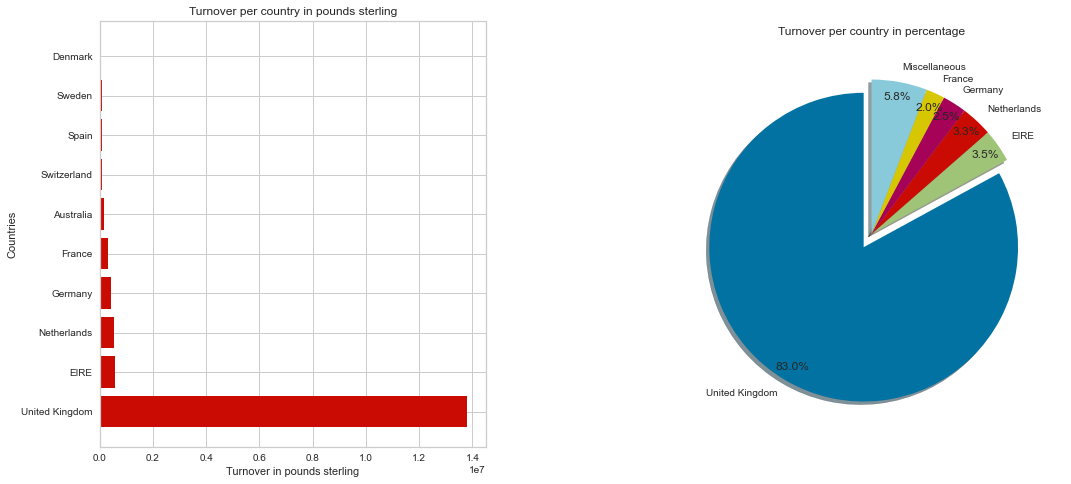

In [398]:
df['Cost Per Invoice'] = df['Quantity'] * df['Price']
top_ten_countries = df.groupby("Country", as_index= False)["Cost Per Invoice"].agg('sum').sort_values(by = "Cost Per Invoice",ascending= False).head(10)
# Figure Size
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
ax[0].barh(top_ten_countries["Country"], top_ten_countries["Cost Per Invoice"], color='r')
 
# Horizontal Bar Plot
ax[0].set_ylabel('Countries')
ax[0].set_xlabel('Turnover in pounds sterling')
ax[0].set_title('Turnover per country in pounds sterling')
# Second Plot
turnover_countries = df.groupby("Country", as_index= False)["Cost Per Invoice"].agg('sum').sort_values(by = "Cost Per Invoice",ascending= False)
turnover_countries["Sales_countries_percentage"] = round(100*(turnover_countries["Cost Per Invoice"])/sum(turnover_countries["Cost Per Invoice"]), 2)
Sales_countries_percentage = turnover_countries[turnover_countries.Sales_countries_percentage < 1.9].sum()
cost = turnover_countries[turnover_countries["Cost Per Invoice"] < 3.165047e+05].sum()
products = turnover_countries.Sales_countries_percentage > 1.9
turnover_countries = turnover_countries[products]
turnover_countries = turnover_countries.append(pd.DataFrame({'Country': ["Miscellaneous"], 'Cost Per Invoice': [cost["Cost Per Invoice"]], 'Sales_countries_percentage': [Sales_countries_percentage["Sales_countries_percentage"]]}))
turnover_countries
# Creating plot
explode = (0.1, 0, 0, 0,0,0)  # only "explode" the first slice (i.e. 'UK')
ax[1].pie(turnover_countries["Sales_countries_percentage"], explode=explode, labels= turnover_countries["Country"], autopct='%1.1f%%',  pctdistance=0.9,
        shadow=True, startangle=90)
ax[1].set_title('Turnover per country in percentage')
# Show Plot
plt.show()

### Return Rate <a id='12'></a> 
The two graphs show the most recalled products and the return rate across all orders. The return rate of 2.3% for all products is very low. <br> 
Returned orders are no longer taken into account for the further investigations because they affect the subsequent market segmentation.

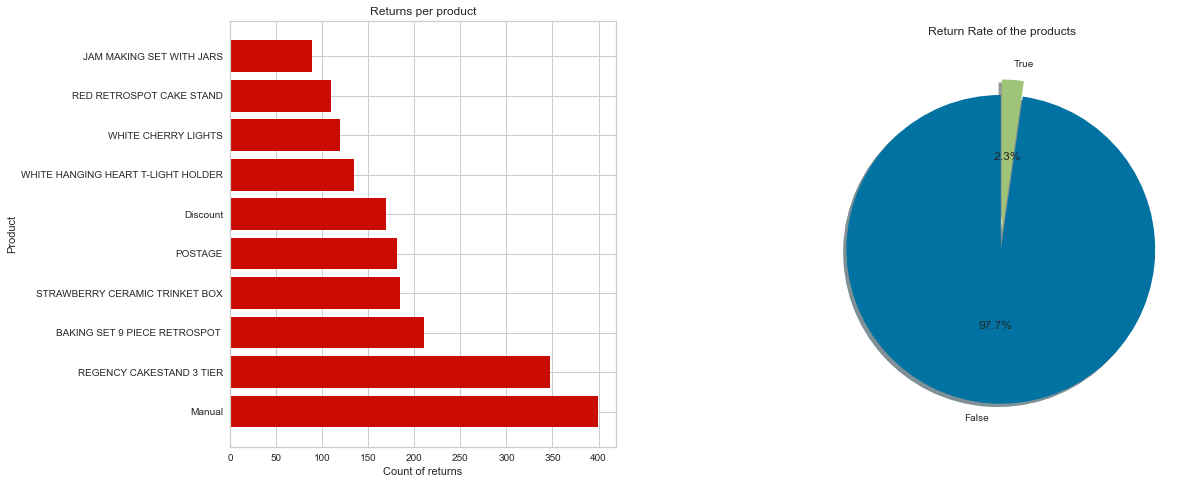

In [399]:
df["Return"] = df.Quantity <0
return_product = df[df.Return == True]
result = return_product.groupby("Description", as_index= False)["Invoice"].agg("count").sort_values(by = "Invoice", ascending= False).head(10)
#result.sort_values(by = "Invoice", ascending= False).head(10)
# Figure Size
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
ax[0].barh(result["Description"], result["Invoice"], color='r')
 
# Horizontal Bar Plot
ax[0].set_ylabel('Product')
ax[0].set_xlabel('Count of returns')
ax[0].set_title('Returns per product')
# second
tmp = df["Return"].value_counts()
explode = (0.1,0)
ax[1].pie(tmp, labels= tmp.index,explode=explode, autopct='%1.1f%%',  pctdistance=0.5,
        shadow=True, startangle=90)
ax[1].set_title('Return Rate of the products')
# Show Plot
plt.show()
#Filter out returned products
return_product = df.Return == False
df = df[return_product]

### Best selling products <a id='13'></a>
When analysing the products, I first checked whether the number of stock codes was the same as the number of labels. <br>
This revealed that some products have different descriptions. This could be improved in the online shop. That's why I only use the stock codes for product analysis. <br>
The online shop has 4631 products, where none of the products take the biggest part in the sale.<br>
This can be seen in the following diagram, where I show the 10 best-selling products. <br> 
In this plot, the number of products sold is compared with the sales revenue per product of the 10 best-selling products. <br>
You can see that, for example, the product with the stock code 84077 is responsible for 1% of the number of goods sold, but only for 0.14% of the turnover per product. <br>
This shows that the number of products sold does not equal the turnover per product.

In [400]:
unique_Stockcode = len(df["StockCode"].unique())
unique_Description = len(df["Description"].unique())
print("There are "+ str(unique_Stockcode)+ " unique Stockcods and "+ str(unique_Description) + " Descriptions for Products." )

There are 4631 unique Stockcods and 5283 Descriptions for Products.


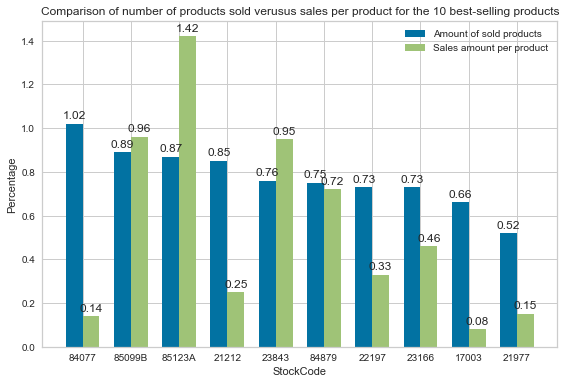

In [401]:
products = df.groupby(["StockCode"], as_index= False).agg(Count_item=('Quantity', 'sum'),Sales_product=('Cost Per Invoice','sum')).sort_values(by = "Count_item",ascending=False)
products["count_product_percentage"] = round(100*(products["Count_item"])/sum(products["Count_item"]), 2)
products["Sales in percenatge"] = round(100*(products["Sales_product"])/sum(products["Sales_product"]), 2)
products.head(10)
x = np.arange(len(products["count_product_percentage"].head(10)))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, products["count_product_percentage"].head(10), width, label='Amount of sold products')
rects2 = ax.bar(x + width/2, products["Sales in percenatge"].head(10), width, label='Sales amount per product')
#Titles
ax.set_ylabel('Percentage')
ax.set_xlabel('StockCode')
ax.set_title('Comparison of number of products sold verusus sales per product for the 10 best-selling products')
ax.set_xticks(x, products["StockCode"].head(10))
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
#Plot
plt.show()

### Customer Analysis <a id='14'></a>
The online shop has 5881 customers. The 10 best customers alone are responsible for 15.93% of the turnover. <br>
In this analysis, only an overview of the customers is to be gained. The clustering will then go into detail about types of customers.

The Online shop has 5881 customer and the top 10 customer are responsible for 15.93% of the turnover.


C:\Users\wuest\AppData\Local\Temp/ipykernel_18688/864251928.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["Customer ID"] = result["Customer ID"].astype(str)


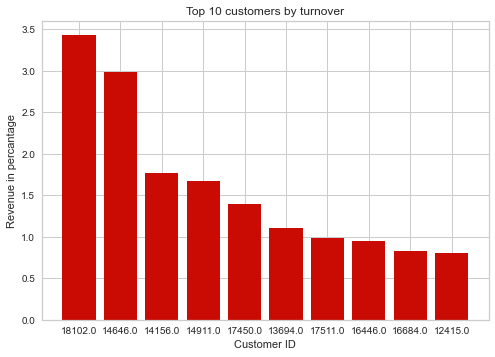

In [402]:
unique_customer = len(df["Customer ID"].unique())
customer = df.groupby("Customer ID", as_index= False).agg(Sales=('Cost Per Invoice', 'sum')).sort_values(by = "Sales",ascending=False)
customer["Sales in Percentage"] = round(100*(customer.Sales)/np.sum(customer.Sales), 2)
result = customer.head(10)
print("The Online shop has " + str(unique_customer)+ " customer and the top 10 customer are responsible for " + str(np.sum(result["Sales in Percentage"])) +"% of the turnover.")
result["Customer ID"] = result["Customer ID"].astype(str) 
plt.bar(result["Customer ID"], result["Sales in Percentage"], color='r')

# Horizontal Bar Plot
plt.xlabel('Customer ID')
plt.ylabel('Revenue in percantage')
plt.title('Top 10 customers by turnover')
plt.show()


### Data Preparation <a id='3'></a> 

After the Data Expolration we found out that the most turnover is made in the UK. Furthermore, we have seen that not one product is bought frequently, <br>
but that all products are bought in similar numbers. In addition, it became clear that a small number of customers are responsible for a large share of the online shop. <br>
The Recency Frequency Monetary (RFM) model is often used for customer segmentation in marketing. This model allows information about customer behaviour to be obtained. <br>
* Recency: How recently customer made a buy. <br>
* Frequency: How often customer buys. <br>
* Monetary: How much amount customer buys <br>

In Data Preparation, the input data frame is adjusted so that it only consists of CustomerId, Recency, Frequency and Monetary. <br>
 This data frame forms the basis for the subsequent clustering.

In [403]:
# df_time = df[(df.year == 2009) ]
df_a = df.groupby(["Invoice","Customer ID", "InvoiceDate"], as_index= False).agg(Items = ("StockCode","nunique"), Amount_of_Products= ("Quantity", "sum"),Total_Price=("Cost Per Invoice","sum"))
df_a.sort_values(by = "InvoiceDate", ascending= True).head()
#Calculation Recency
df_recency = df_a.groupby(by='Customer ID',
                        as_index=False)['InvoiceDate'].max()
df_recency.columns = ['Customer ID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
# Calculation Frequency
frequency_df = df_a.drop_duplicates().groupby(
    by=['Customer ID'], as_index=False)['InvoiceDate'].count()
frequency_df.columns = ['Customer ID', 'Frequency']
# Calculation Monetary
monetary_df = df_a.groupby(by='Customer ID', as_index=False)['Total_Price'].sum()
monetary_df.columns = ['Customer ID', 'Monetary']
# Combing all attributes
all_df = [df_recency,frequency_df,monetary_df]
rfm_df = reduce(lambda left,right: pd.merge(left,right,on='Customer ID'), all_df)
rfm_df = rfm_df.set_index('Customer ID')
rfm_df = rfm_df[["Recency",'Frequency','Monetary']]
rfm_df.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,325,12,77556.46
12347.0,1,8,5633.32
12348.0,74,5,2019.40
12349.0,18,4,4428.69
12350.0,309,1,334.40


In [404]:
def viewDistribution(df):
    sns.boxplot(data=df)
    plt.xticks(rotation=90)
    plt.show

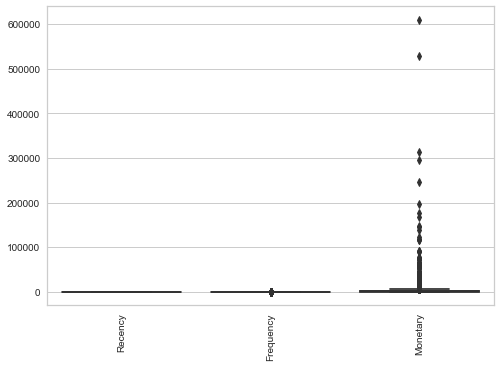

In [405]:
# Creating plot
viewDistribution(rfm_df)


In [406]:
# UDF to remove outlier
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

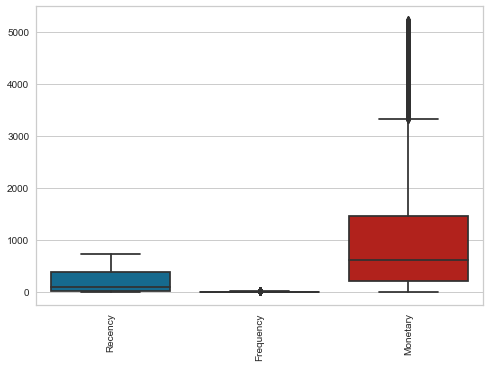

In [407]:
df_IQR = remove_outlier_IQR(rfm_df)
df_IQR.fillna(0,inplace=True)
viewDistribution(df_IQR)

Since the values are in different units and scales, the values must be standardised.

In [408]:
rfm_df_copy = df_IQR
#StandartScaler
scaler = StandardScaler()
# transform data
rfm_df_sc = pd.DataFrame(scaler.fit_transform(df_IQR.values), columns=rfm_df.columns, index=rfm_df.index)
rfm_df_sc.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,0.594598,2.300938,-0.896115
12347.0,-0.952264,1.186084,-0.896115
12348.0,-0.603743,0.349944,0.824729
12349.0,-0.871102,0.071230,2.877820
12350.0,0.518209,-0.764910,-0.611154


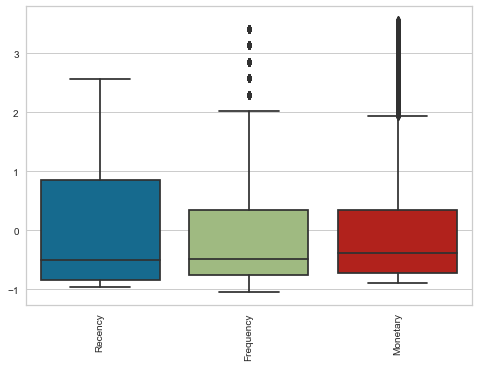

In [409]:
# Creating plot
viewDistribution(rfm_df_sc)

In [410]:
# Create evaluation dataframe 
evaluation_df = pd.DataFrame({'Clustering':[], 'silhouette_score':[],'best_cluster_size':[], 'cluster_size':[],'labeled_data':[]})

In [411]:
def plot_clusters_with_centers(model, X,i, measure, linkage):
    if model == "KMeans":
        clf=KMeans(n_clusters=i, random_state=1)
        y_pred = clf.fit_predict(X)
        fig, ax = plt.subplots(1,3)
        plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
        for i in range(0,len(np.unique(y_pred))):
            ax[0].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        # Horizontal Bar Plot
        ax[0].set_ylabel('Monetary')
        ax[0].set_xlabel('Recency')
        ax[0].set_title('Clustering View Recency vs Monetary')
        ax[0].legend()
        # second
        for i in range(0,len(np.unique(y_pred))):
            ax[1].scatter(X.iloc[y_pred==i, 1], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        ax[1].set_ylabel('Monetary')
        ax[1].set_xlabel('Frequency')
        ax[1].set_title('Clustering View Frequency vs Monetary')
        ax[1].legend()
        for i in range(0,len(np.unique(y_pred))):
            ax[2].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 1], c=colors[i], label=i, marker = '.')
        ax[2].set_ylabel('Recency')
        ax[2].set_xlabel('Frequency')
        ax[2].set_title('Clustering View Frequency vs Monetary')
        ax[2].legend()
        # Show Plot
        plt.show()
    elif model == "agg":
        clf=cluster.AgglomerativeClustering(n_clusters=i, affinity=measure, linkage=linkage, compute_distances=True)
        y_pred = clf.fit_predict(X)
        fig, ax = plt.subplots(1,3)
        plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
        for i in range(0,len(np.unique(y_pred))):
            ax[0].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        # Horizontal Bar Plot
        ax[0].set_ylabel('Monetary')
        ax[0].set_xlabel('Recency')
        ax[0].set_title('Clustering View Recency vs Monetary')
        ax[0].legend()
        # second
        for i in range(0,len(np.unique(y_pred))):
            ax[1].scatter(X.iloc[y_pred==i, 1], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        ax[1].set_ylabel('Monetary')
        ax[1].set_xlabel('Frequency')
        ax[1].set_title('Clustering View Frequency vs Monetary')
        ax[1].legend()
        for i in range(0,len(np.unique(y_pred))):
            ax[2].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 1], c=colors[i], label=i, marker = '.')
        ax[2].set_ylabel('Recency')
        ax[2].set_xlabel('Frequency')
        ax[2].set_title('Clustering View Frequency vs Monetary')
        ax[2].legend()
        # Show Plot
        plt.show()
    elif model == "fcm":
        fcm = FCM(n_clusters=i)
        fcm.fit(X.to_numpy())
        y_pred = fcm.predict(X.to_numpy())
        fig, ax = plt.subplots(1,3)
        plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
        for i in range(0,len(np.unique(y_pred))):
            ax[0].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        # Horizontal Bar Plot
        ax[0].set_ylabel('Monetary')
        ax[0].set_xlabel('Recency')
        ax[0].set_title('Clustering View Recency vs Monetary')
        ax[0].legend()
        # second
        for i in range(0,len(np.unique(y_pred))):
            ax[1].scatter(X.iloc[y_pred==i, 1], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        ax[1].set_ylabel('Monetary')
        ax[1].set_xlabel('Frequency')
        ax[1].set_title('Clustering View Frequency vs Monetary')
        ax[1].legend()
        for i in range(0,len(np.unique(y_pred))):
            ax[2].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 1], c=colors[i], label=i, marker = '.')
        ax[2].set_ylabel('Recency')
        ax[2].set_xlabel('Frequency')
        ax[2].set_title('Clustering View Frequency vs Monetary')
        ax[2].legend()
        # Show Plot
        plt.show()

In [412]:
def calculate_silhouette_score(model, k_min,k_max,df,measure,linkage):
    silhouettes=[]
    i = k_min
    if model == "KMeans":
        for i in range(k_min,k_max+1):   
            clf=KMeans(n_clusters=i, random_state=1) # <- by default, this runs k-means++, starting over 10 times, reporting the best result
            y_pred = clf.fit_predict(df)
            print(silhouette_score(df,y_pred))
            silhouettes.append(silhouette_score(df,y_pred))        
    elif model == "agg":
        for i in range(k_min,k_max+1): 
            clf=cluster.AgglomerativeClustering(n_clusters=i, affinity=measure, linkage=linkage, compute_distances=True)
            y_pred = clf.fit_predict(df)
            print(silhouette_score(df,y_pred))
            silhouettes.append(silhouette_score(df,y_pred))
    elif model == "fcm":
        for i in range(k_min,k_max+1): 
            fcm = FCM(n_clusters=i)
            fcm.fit(rfm_df_sc.to_numpy())
            fcm_labels = fcm.predict(rfm_df_sc.to_numpy())
            print(silhouette_score(df,fcm_labels))
            silhouettes.append(silhouette_score(df,fcm_labels))      
    return silhouettes

In [413]:
def plot_silhouette_score(k_min,k_max,silhouette):
    reload(plt)
    plt.xlabel('k')
    plt.ylabel('Silhouette Coefficient')
    plt.plot(range(k_min,k_max+1), silhouette)
    plt.legend()
    return plt.show()

In [414]:
def plot_elbow_method(model,data,min, max):
    sse = []
    for k in range(min,max+1):
        if model == "KMeans":
            clf = KMeans(n_clusters=k, random_state=1)
            clf.fit(data)
            sse.append(clf.inertia_)
        elif model == "agg":
            clf=cluster.AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='complete', compute_distances=True)
            clf.fit(data)
            sse.append(clf.inertia_)

    #Elbow Method    
    plt.plot(sse, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()

In [415]:
def create_boxplot(df):
    f, axes = plt.subplots(1, 3)
    plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
    sns.boxplot(x='cluster', y='Frequency', data=df, ax = axes[0]);
    sns.boxplot(x='cluster', y='Monetary',data=df,ax = axes[1]);
    sns.boxplot(x='cluster', y='Recency',data=df,ax = axes[2]);

### Partitioning Clustering with K-means <a id='4'></a> 
The aim is to use K-Means clustering to identify patterns in customer types. The RFM method is used as a basis. <br>
The first step in K-Menas clustering is to find out what the best number of clusters k is. There are several methods to do this. <br>
In the following, the Silhouette method and the Elbow method are used.

In [416]:
def visualize_silhouette_score(kmeans,color,X):
    visualizer = SilhouetteVisualizer(kmeans, colors=color, is_fitted=True)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.finalize()
    print(visualizer.silhouette_samples_)
    print(f'Silhoutte score: {visualizer.silhouette_score_}')
    #visualizer.poof(outpath="3.5_sil.jpg")
    return visualizer.show()        # Finalize and render the figure

In [417]:
def calculate_kmeans(data, clustersize):
    clf=KMeans(n_clusters=clustersize, random_state=1) # <- by default, this runs k-means++, starting over 10 times, reporting the best result
    y_pred = clf.fit_predict(data)
    return clf

0.42686455262814926
0.43216645667476716
0.4172464596552419
0.4217277040653359
0.4180345135854774
0.39474243877130255
0.3693957410510535
0.38474030575662355
0.3760506001414916


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


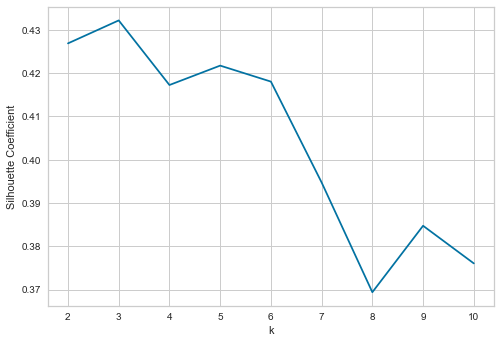

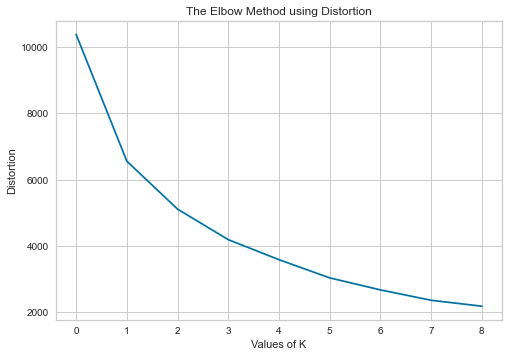

In [418]:
k_min = 2
k_max = 10
silhouette = calculate_silhouette_score("KMeans",k_min,k_max,rfm_df_sc,'','')
plot_silhouette_score(k_min,k_max,silhouette)
plot_elbow_method("KMeans",rfm_df_sc,k_min,k_max)


In [419]:
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['K-Means'], 'silhouette_score':[0.432], 'best_cluster_size':[3], 'cluster_size':[3]}),ignore_index=True)
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['K-Means'], 'silhouette_score':[0.421], 'best_cluster_size':[3], 'cluster_size':[5]}),ignore_index=True)

#### K-Means with 3 Clusters

0.43216645667476716


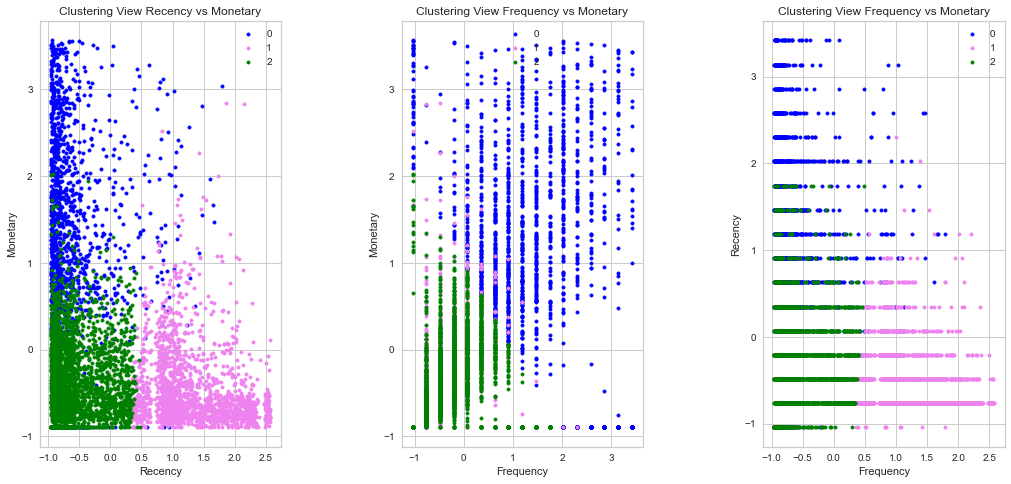

In [420]:
colors=['blue', 'violet','green', 'black','orange','red']
silhouette = calculate_silhouette_score("KMeans",3,3,rfm_df_sc,'','')
plot_clusters_with_centers("KMeans", rfm_df_sc,3,'','')

In [425]:
kmeans= calculate_kmeans(rfm_df_sc,3)
rfm_df_copy["cluster"] = kmeans.labels_
evaluation_df.iloc[0,4] = [np.array(rfm_df_copy, dtype=object)]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

2    2695
1    1808
0    1378
Name: cluster, dtype: int64


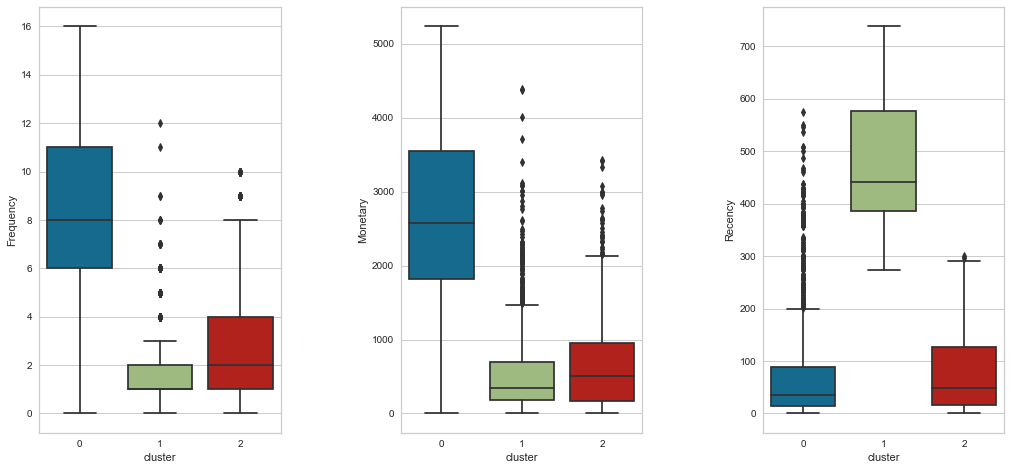

In [ ]:
create_boxplot(rfm_df_copy)

0.43216645667476716


C:\Users\wuest\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


[ 0.01253072  0.30170173 -0.11191656 ...  0.62494108  0.52083198
  0.41925741]
Silhoutte score: 0.43216645667476716


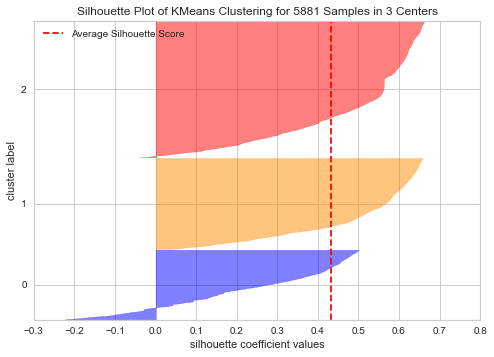

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5881 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
colors=['blue', 'darkorange','red', 'black','orange','green']
silhouette = calculate_silhouette_score("KMeans",3,3,rfm_df_sc,'','')
kmeans= calculate_kmeans(rfm_df_sc,3)
visualize_silhouette_score(kmeans,colors,rfm_df_sc)

#### K-Means with 5 Cluster

0.4217277040653359


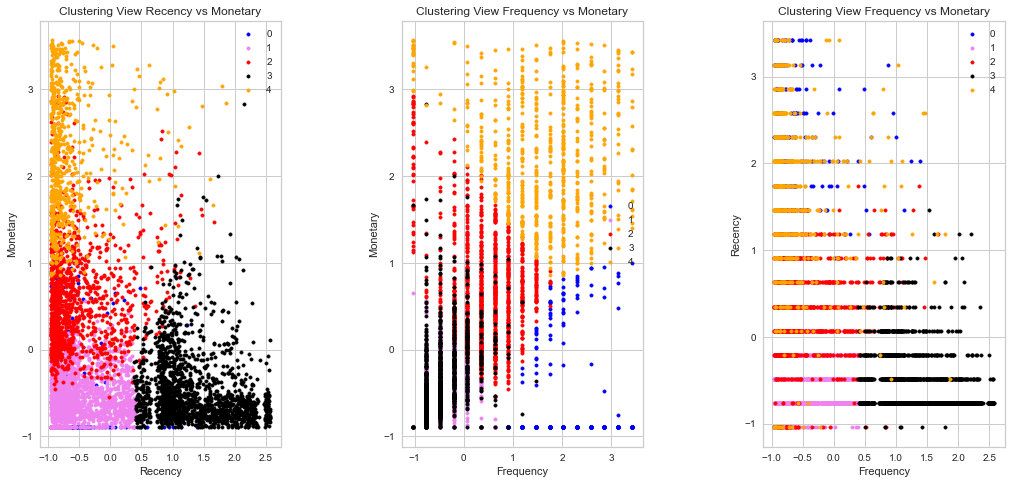

In [ ]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("KMeans",5,5,rfm_df_sc,'','')
plot_clusters_with_centers("KMeans", rfm_df_sc,5,'','')

0.4217277040653359


C:\Users\wuest\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


[0.42334741 0.30695394 0.48295288 ... 0.62714784 0.52153444 0.38430065]
Silhoutte score: 0.4217277040653359


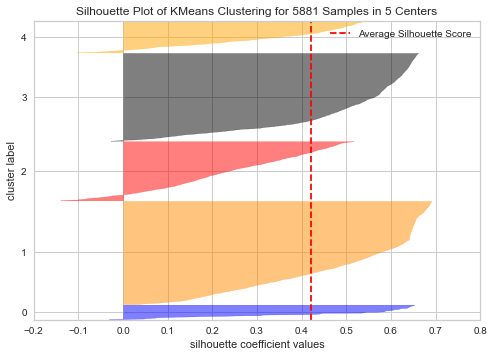

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5881 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
colors=['blue', 'darkorange','red', 'black','orange','green']
silhouette = calculate_silhouette_score("KMeans",5,5,rfm_df_sc,'','')
kmeans= calculate_kmeans(rfm_df_sc,5)
visualize_silhouette_score(kmeans,colors,rfm_df_sc)

In [ ]:
kmeans= calculate_kmeans(rfm_df_sc,5)
rfm_df_copy["cluster"] = kmeans.labels_
evaluation_df.iloc[1,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

1    2052
3    1744
2    1176
4     617
0     292
Name: cluster, dtype: int64


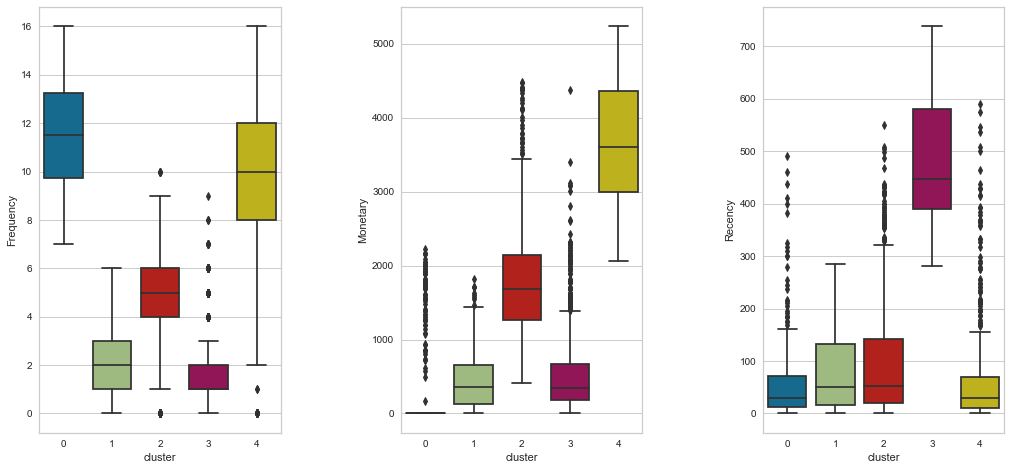

In [ ]:
create_boxplot(rfm_df_copy)

## Hierarchical Clustering <a id='5'></a> 

In [ ]:
def calculate_hierach_cluster(data, clustersize, measure, linkage):
    clf=cluster.AgglomerativeClustering(n_clusters=clustersize, affinity=measure, linkage=linkage, compute_distances=True)
    y_pred = clf.fit_predict(data)
    return clf

In [ ]:
def plot_silhouette_score_agg(k_min,k_max,silhouette,linkage,measure):
    reload(plt)
    plt.xlabel('k')
    plt.ylabel('Silhouette Coefficient')
    plt.plot(range(k_min,k_max+1), silhouette)
    plt.title(f'Distance {measure} and Linkage {linkage}')
    plt.legend()
    return plt.show()

In [ ]:
def create_linkage(agg):
    n_samples = len(agg.labels_)
    counts = np.zeros(agg.children_.shape[0])
    for i, merge in enumerate(agg.children_):
        current_count = 0
        #print (i, merge)
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([agg.children_, agg.distances_,counts]).astype(float)
    return linkage_matrix

In [ ]:
def create_linkage(agg):
    n_samples = len(agg.labels_)
    counts = np.zeros(agg.children_.shape[0])
    for i, merge in enumerate(agg.children_):
        current_count = 0
        #print (i, merge)
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([agg.children_, agg.distances_,counts]).astype(float)
    return linkage_matrix

In [ ]:
def agglomerate(measure, cluster_size, linkage_type, df):
    agg = cluster.AgglomerativeClustering(cluster_size, affinity=measure, linkage= linkage_type, compute_distances=True)
    labels = agg.fit_predict(df)
    rfm_df_copy["cluster"] = agg.labels_
    distribution = rfm_df_copy['cluster'].value_counts()
    print('Cluster distribution:')
    print(f'Distance {measure} and Linkage {linkage_type}')
    print(distribution)
    plt.figure(figsize=(8,5))
    cols=['red', 'green', 'blue', 'violet', 'orange']
    for i in range(0,len(np.unique(labels))):
        plt.scatter(df.iloc[labels==i, 0], df.iloc[labels==i, 2], c=cols[i], label=i, marker = '.')
        plt.ylabel('Monetary')
        plt.xlabel('Recency')
        plt.title(f'Clustering View Recency vs Monetary for 'f'Distance {measure} and Linkage {linkage_type}')
        plt.legend()
    hierarchy.set_link_color_palette(['red', 'green', 'blue', 'violet', 'orange'])
    plt.figure(figsize=(18,5))
    if str(measure).__contains__("function"):
        measure = "Pearson"
    dendrogram(
        create_linkage(agg),
        color_threshold=agg.distances_[-cluster_size + 1], #use agg.distances[-desired amount of cluster + 1] for coloring
        orientation='left',
        labels=df.index,
        leaf_rotation=0)
    plt.title(f'Distance {measure} and Linkage {linkage_type}')
    #plt.savefig(f'decathlon_dendrogram_{measure}_{linkage_type}.pdf')
    plt.show()

In [ ]:
evaluation_hier_df = pd.DataFrame({'Clustering':[],'Linkage':[], 'Measure':[],'Cluster_size':[] ,'silhouette_score':[],'best_cluster_size':[], 'second_best_size':[]})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


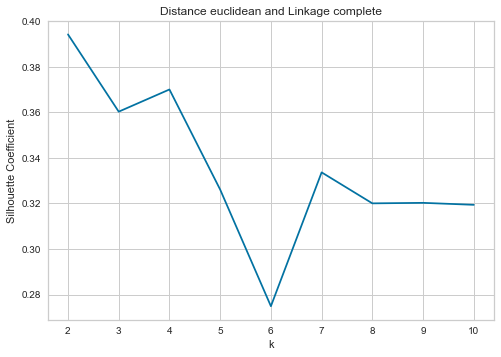

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


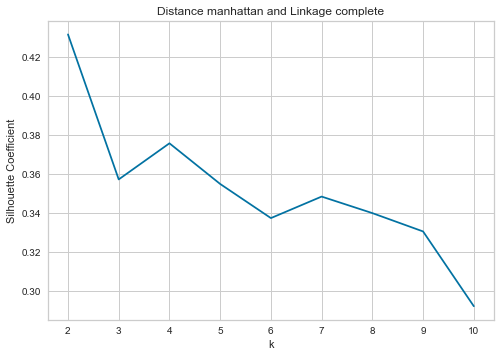

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


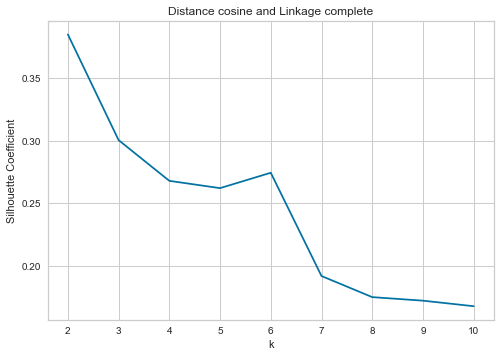

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


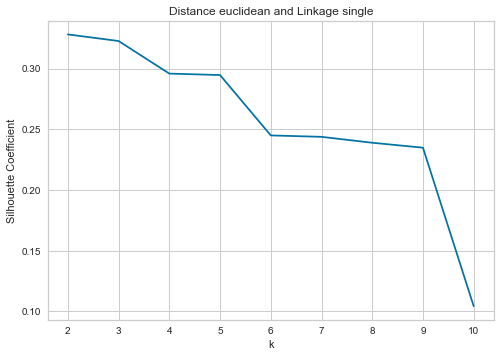

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


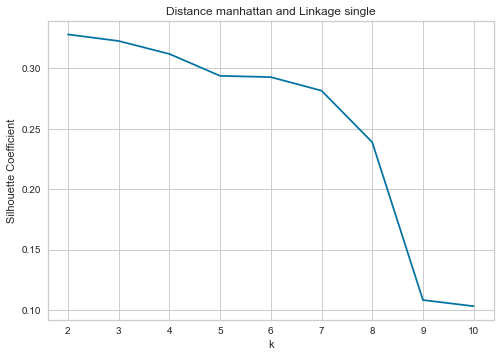

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


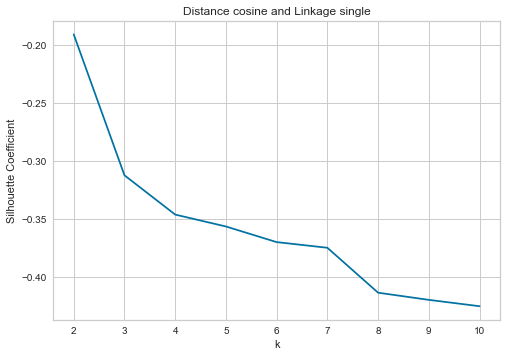

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


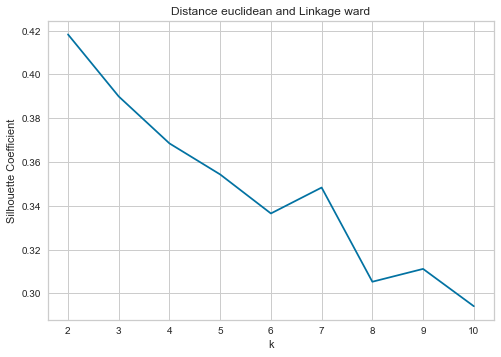

In [ ]:
k_min = 2
k_max = 10
for linkage in ["complete", "single", "ward"]:
    if linkage == "ward":
        silhouettes=[]
        for i in range(k_min,k_max+1): 
            clf=cluster.AgglomerativeClustering(n_clusters=i, affinity="euclidean", linkage=linkage, compute_distances=True)
            y_pred = clf.fit_predict(rfm_df_sc)
            evaluation_hier_df = evaluation_hier_df.append(pd.DataFrame({'Clustering':['Hierarchical Clustering'], 'Linkage':[linkage], 'Measure':["euclidean"],'Cluster_size':[i],'silhouette_score':[silhouette_score(rfm_df_sc,y_pred)] }),ignore_index=True)
            silhouettes.append(silhouette_score(rfm_df_sc,y_pred))
        plot_silhouette_score_agg(k_min,k_max,silhouettes,linkage,"euclidean")
        break
    else:
        for measure in ["euclidean","manhattan","cosine"]:   
            silhouettes=[]
            for i in range(k_min,k_max+1): 
                clf=cluster.AgglomerativeClustering(n_clusters=i, affinity=measure, linkage=linkage, compute_distances=True)
                y_pred = clf.fit_predict(rfm_df_sc)
                evaluation_hier_df = evaluation_hier_df.append(pd.DataFrame({'Clustering':['Hierarchical Clustering'], 'Linkage':[linkage], 'Measure':[measure],'Cluster_size':[i],'silhouette_score':[silhouette_score(rfm_df_sc,y_pred)] }),ignore_index=True)
                silhouettes.append(silhouette_score(rfm_df_sc,y_pred))
            plot_silhouette_score_agg(k_min,k_max,silhouettes,linkage,measure)

In [ ]:
type_group_df = evaluation_hier_df.groupby(["Linkage", "Measure"], group_keys=False).apply(pd.DataFrame.nlargest,n=2,columns='silhouette_score')

In [ ]:
type_group_df

,Clustering,Linkage,Measure,Cluster_size,silhouette_score,best_cluster_size,second_best_size
18,Hierarchical Clustering,complete,cosine,2.0,0.384939,NaN,NaN
19,Hierarchical Clustering,complete,cosine,3.0,0.300535,NaN,NaN
0,Hierarchical Clustering,complete,euclidean,2.0,0.394262,NaN,NaN
2,Hierarchical Clustering,complete,euclidean,4.0,0.370071,NaN,NaN
9,Hierarchical Clustering,complete,manhattan,2.0,0.431694,NaN,NaN
11,Hierarchical Clustering,complete,manhattan,4.0,0.375824,NaN,NaN
45,Hierarchical Clustering,single,cosine,2.0,-0.191169,NaN,NaN
46,Hierarchical Clustering,single,cosine,3.0,-0.312393,NaN,NaN
27,Hierarchical Clustering,single,euclidean,2.0,0.328108,NaN,NaN
28,Hierarchical Clustering,single,euclidean,3.0,0.322665,NaN,NaN


Cluster distribution:
Distance euclidean and Linkage complete
2    4332
0     688
1     547
3     262
4      52
Name: cluster, dtype: int64


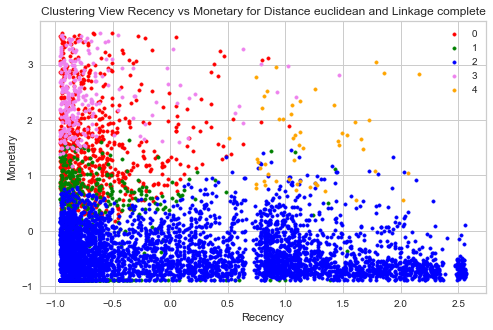

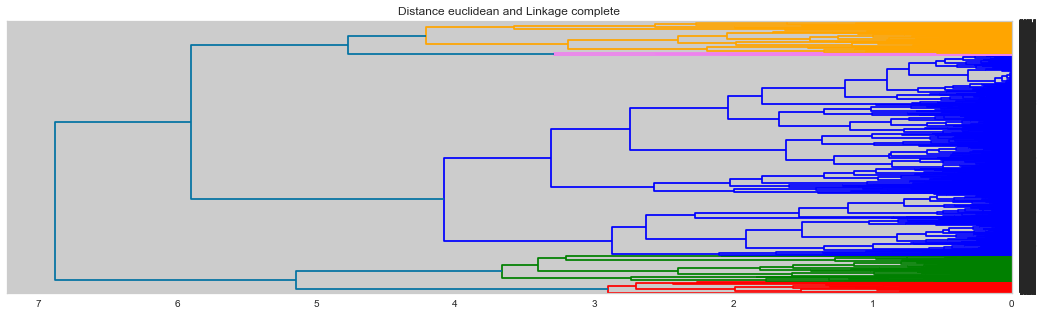

Cluster distribution:
Distance manhattan and Linkage complete
2    2470
0    2294
1     563
3     345
4     209
Name: cluster, dtype: int64


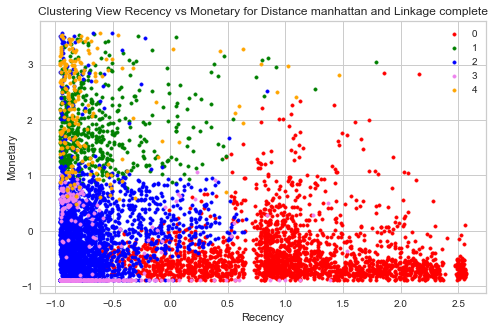

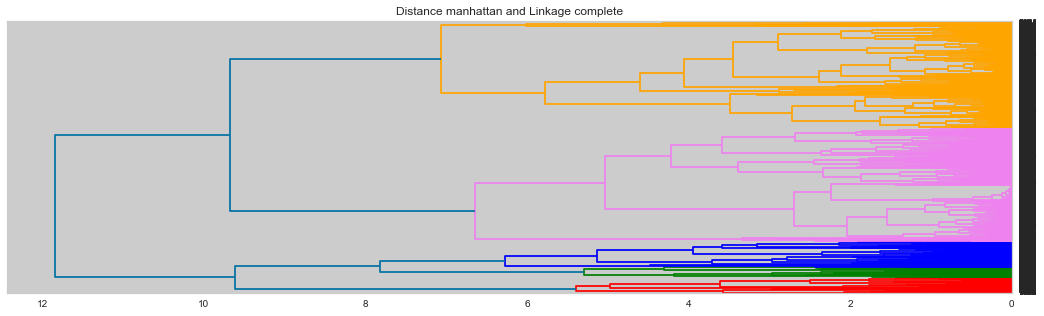

Cluster distribution:
Distance cosine and Linkage complete
3    1763
1    1226
0    1144
4     921
2     827
Name: cluster, dtype: int64


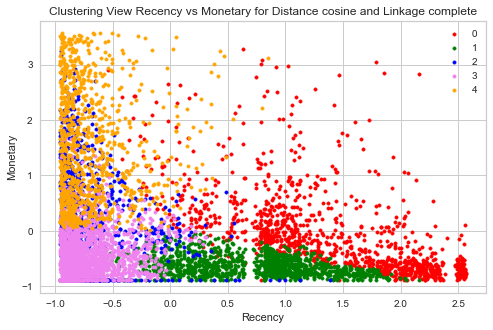

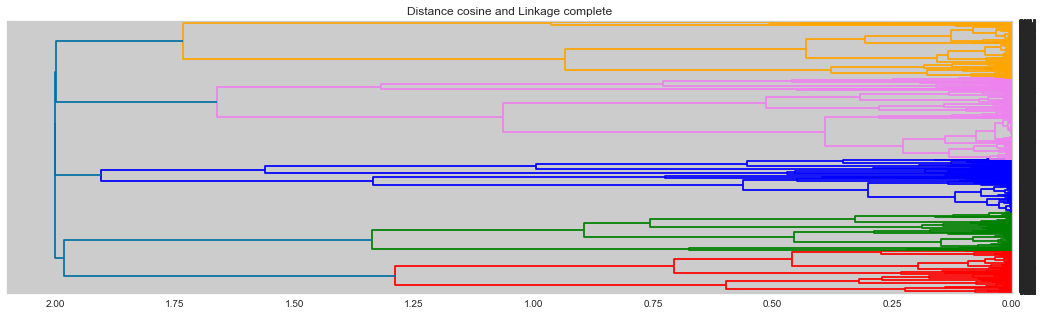

Cluster distribution:
Distance euclidean and Linkage single
0    5876
1       2
4       1
2       1
3       1
Name: cluster, dtype: int64


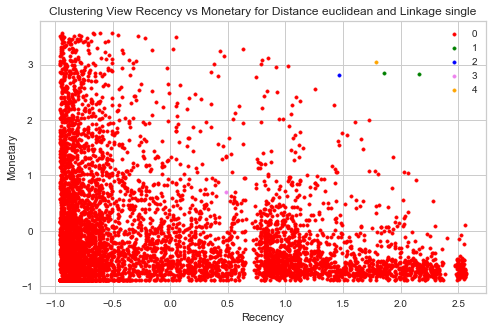

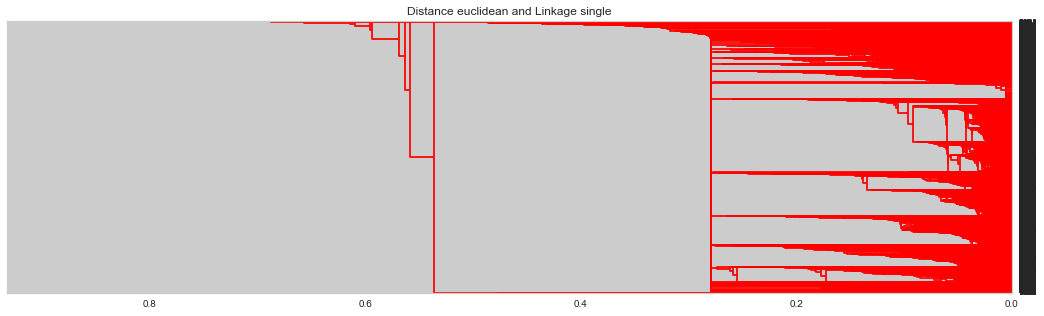

Cluster distribution:
Distance manhattan and Linkage single
0    5876
1       2
3       1
2       1
4       1
Name: cluster, dtype: int64


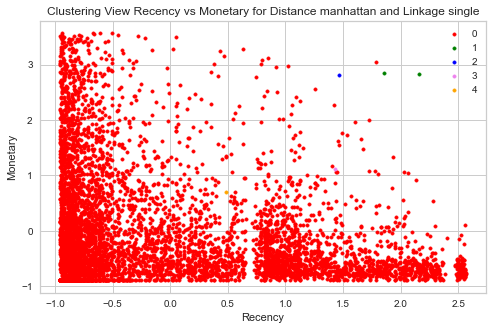

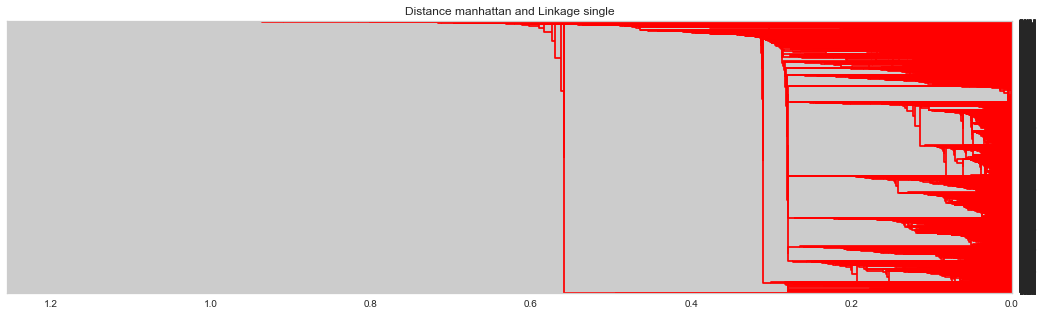

Cluster distribution:
Distance cosine and Linkage single
0    5858
1      10
4       8
2       3
3       2
Name: cluster, dtype: int64


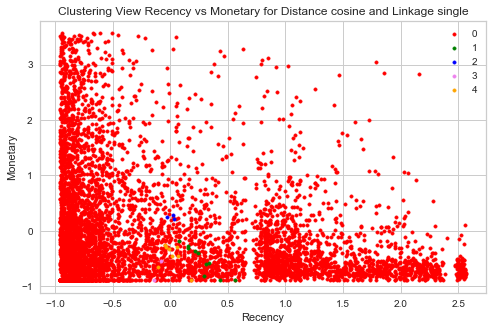

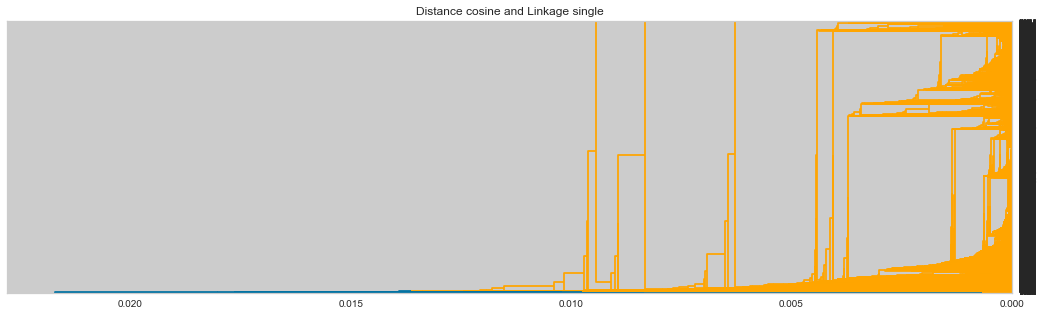

Cluster distribution:
Distance euclidean and Linkage ward
2    2372
0    1878
1     813
3     642
4     176
Name: cluster, dtype: int64


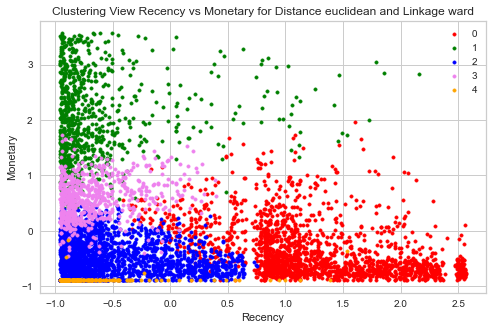

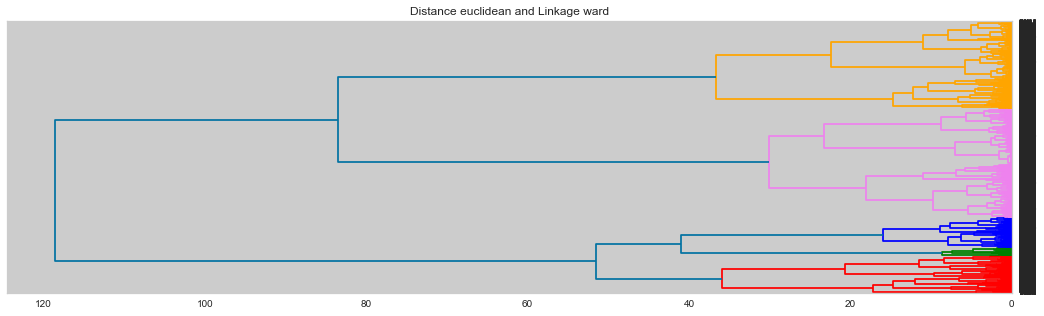

In [ ]:
for linkage in ["complete", "single", "ward"]:
    if linkage == "ward":
        agglomerate("euclidean",5,linkage, rfm_df_sc)
        break
    else:
        for measure in ["euclidean","manhattan","cosine"]:
            agglomerate(measure,5,linkage, rfm_df_sc)

In [ ]:
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['Hierarchical Clustering'], 'silhouette_score':[0.394], 'best_cluster_size':[2], 'cluster_size':[2]}),ignore_index=True)
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['Hierarchical Clustering'], 'silhouette_score':[0.370], 'best_cluster_size':[2], 'cluster_size':[4]}),ignore_index=True)

#### Hierarchical Clustering Cluster size = 2

0.4316939134753964


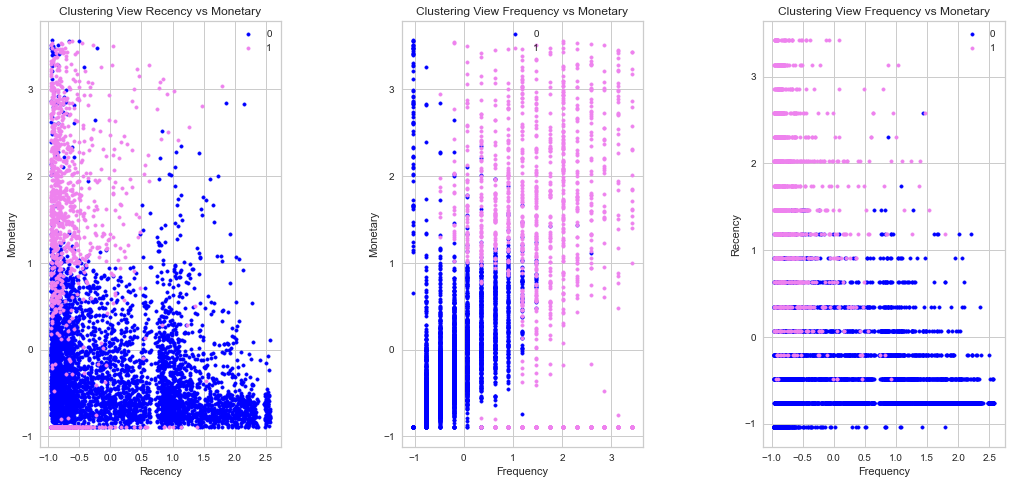

In [ ]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("agg",2,2,rfm_df_sc,"manhattan", 'complete')
plot_clusters_with_centers("agg", rfm_df_sc,2,"manhattan", 'complete')

In [ ]:
agg= calculate_hierach_cluster(rfm_df_sc,2,'manhattan', 'complete')
rfm_df_copy["cluster"] = agg.labels_
evaluation_df.iloc[2,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

0    4764
1    1117
Name: cluster, dtype: int64


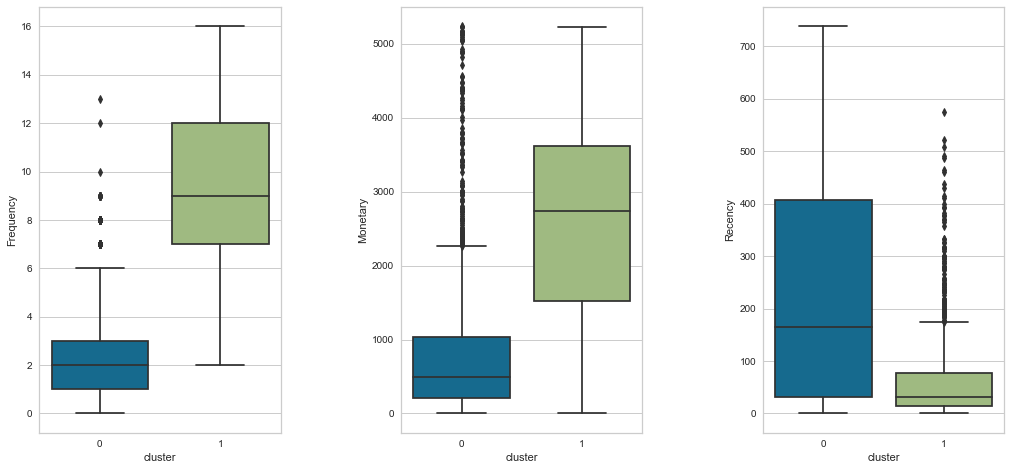

In [ ]:
create_boxplot(rfm_df_copy)

#### Hierarchical Clustering Cluster size = 4

0.3758236240161497


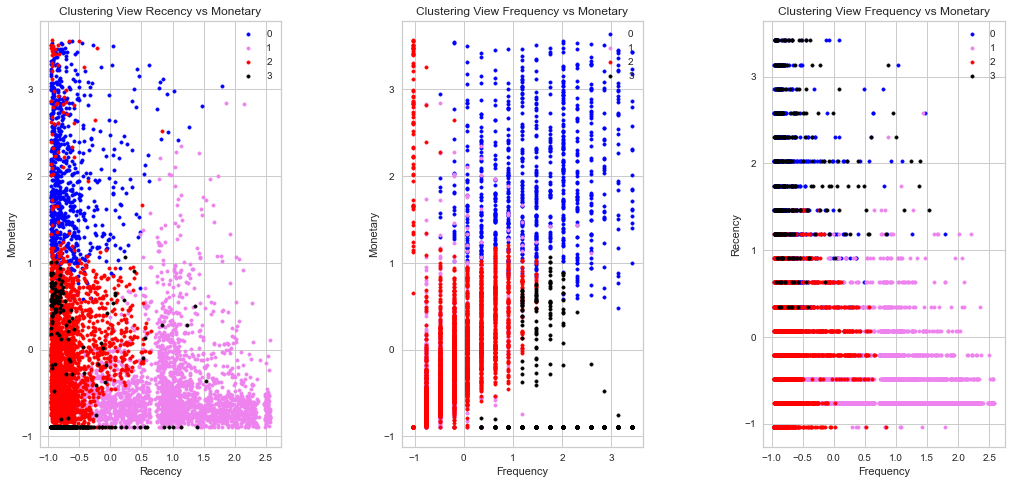

In [ ]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("agg",4,4,rfm_df_sc,'manhattan', 'complete')
plot_clusters_with_centers("agg", rfm_df_sc,4, 'manhattan', 'complete')

In [ ]:
agg= calculate_hierach_cluster(rfm_df_sc,4,'manhattan', 'complete')
rfm_df_copy["cluster"] = agg.labels_
evaluation_df.iloc[3,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

2    2470
1    2294
0     772
3     345
Name: cluster, dtype: int64


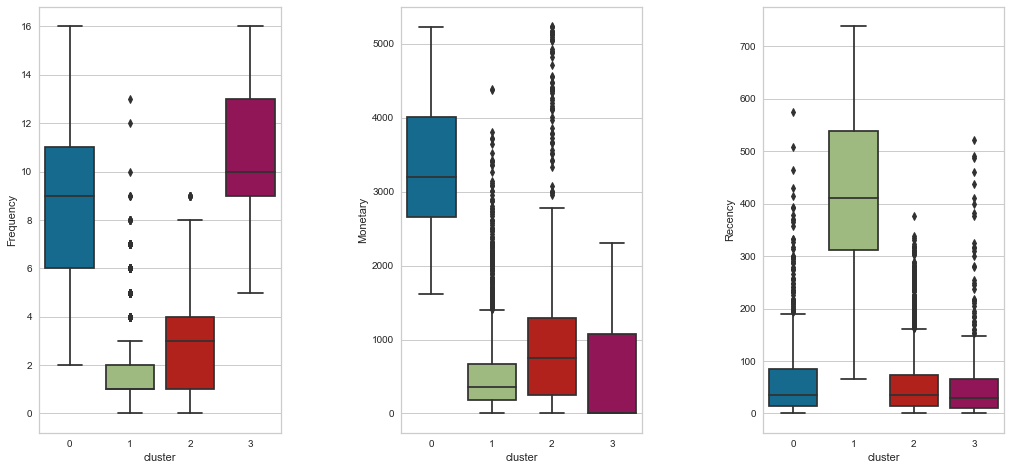

In [ ]:
create_boxplot(rfm_df_copy)

## Fuzzy Clustering <a id='6'></a> 

In [ ]:
def calculate_fcm_cluster(data, clustersize):
    fcm = FCM(n_clusters=clustersize)
    fcm.fit(data.to_numpy())
    fcm_labels = fcm.predict(data.to_numpy())
    return fcm_labels

0.40356949037718537
0.4320865863449068
0.3982904942104391
0.34237891054508734
0.32627487536907795
0.354804044640088
0.35288436583495963
0.34318126115972303
0.32394659561616906


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


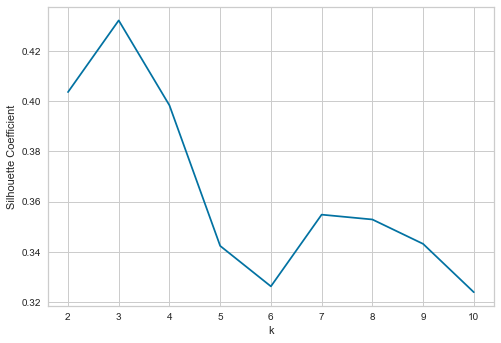

In [ ]:
colors=['blue', 'violet','red', 'black','orange','green']
k_min = 2
k_max = 10
silhouette = calculate_silhouette_score("fcm",k_min,k_max,rfm_df_sc,'', '')
plot_silhouette_score(k_min,k_max,silhouette)

In [ ]:
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['Fuzzy Clustering'], 'silhouette_score':[0.432], 'best_cluster_size':[3], 'cluster_size':[3]}),ignore_index=True)
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['Fuzzy Clustering'], 'silhouette_score':[0.403], 'best_cluster_size':[3], 'cluster_size':[2]}),ignore_index=True)
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['Fuzzy Clustering'], 'silhouette_score':[0.398], 'best_cluster_size':[3], 'cluster_size':[4]}),ignore_index=True)

#### Fuzzy Clustering Cluster size = 3

0.4320865863449068


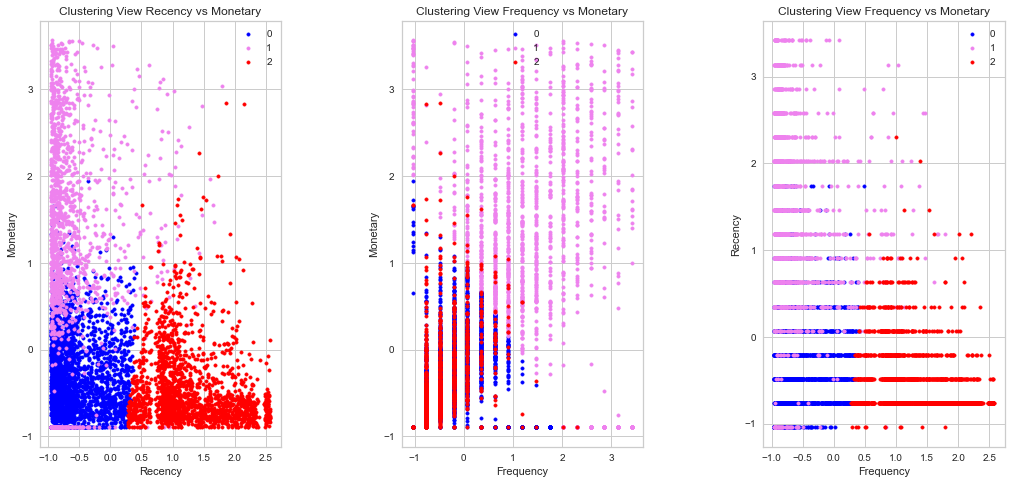

In [ ]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("fcm",3,3,rfm_df_sc,'', '')
plot_clusters_with_centers("fcm", rfm_df_sc,3, '', '')

In [ ]:
rfm_df_copy["cluster"] = calculate_fcm_cluster(rfm_df_sc,3)
evaluation_df.iloc[4,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

2    2677
0    1860
1    1344
Name: cluster, dtype: int64


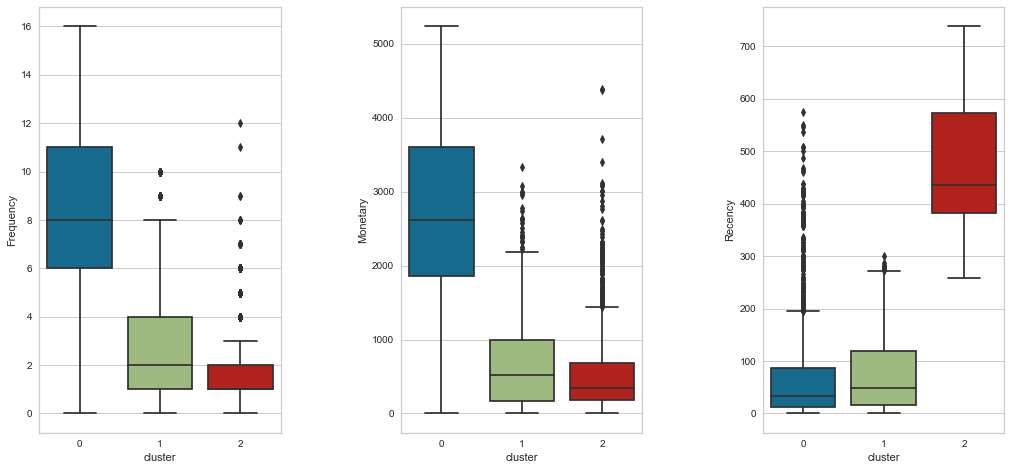

In [ ]:
create_boxplot(rfm_df_copy)


#### Fuzzy Clustering Cluster size = 2

0.40356949037718537


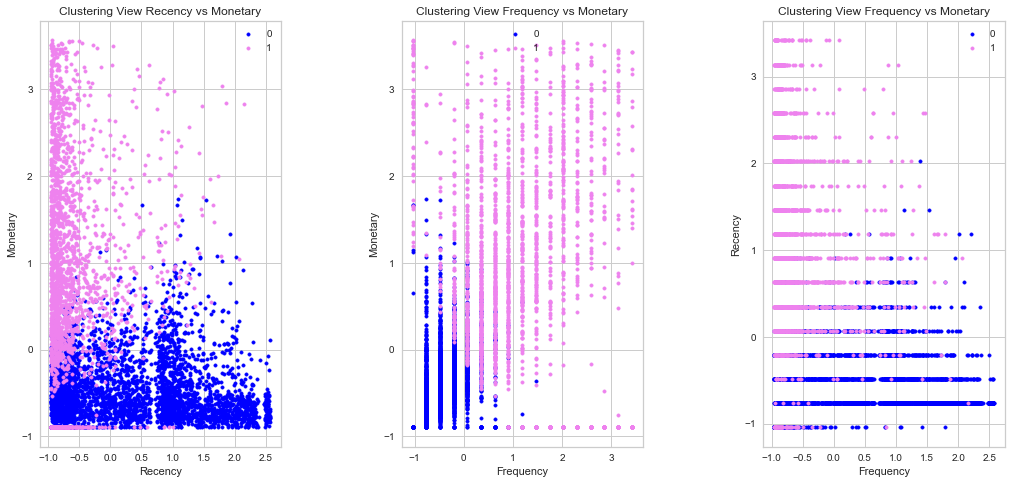

In [ ]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("fcm",2,2,rfm_df_sc,'', '')
plot_clusters_with_centers("fcm", rfm_df_sc,2, '', '')

In [ ]:
rfm_df_copy["cluster"] = calculate_fcm_cluster(rfm_df_sc,2)
evaluation_df.iloc[5,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

0    3909
1    1972
Name: cluster, dtype: int64


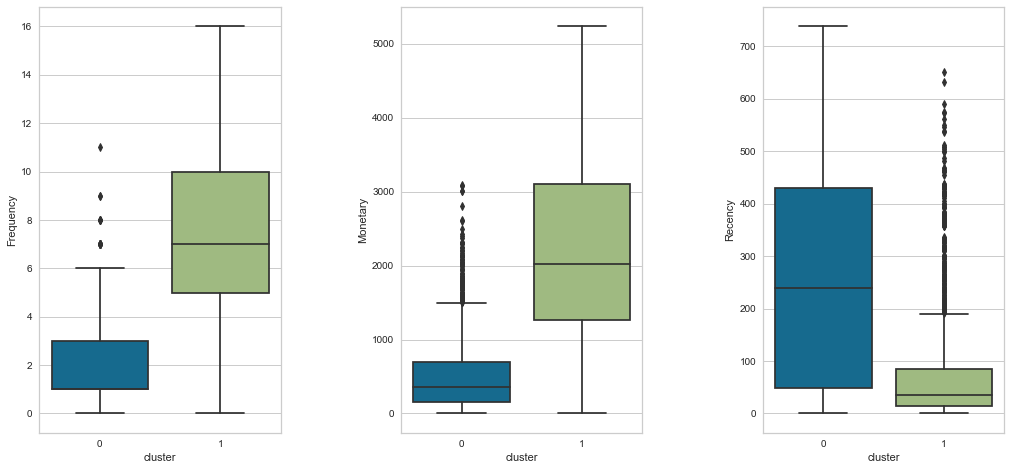

In [ ]:
create_boxplot(rfm_df_copy)

#### Fuzzy Clustering Cluster size = 4

0.3982904942104391


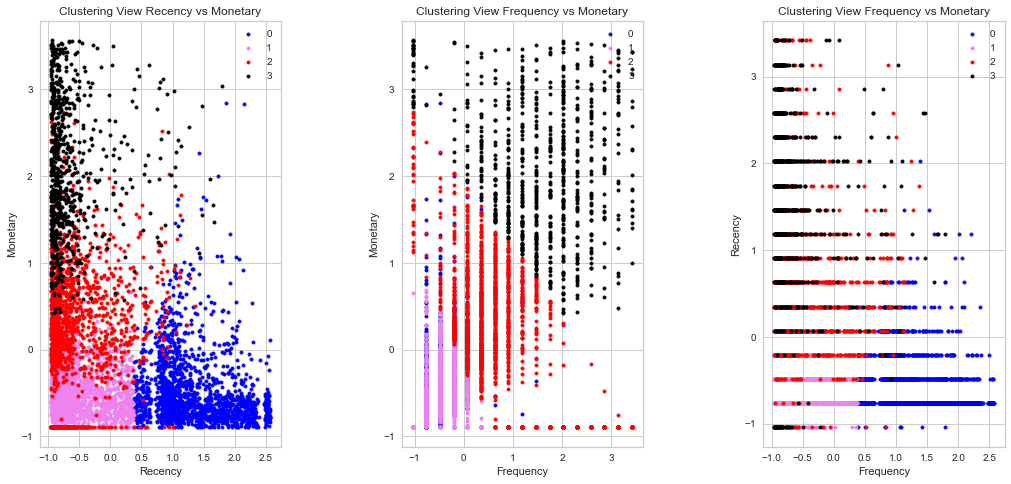

In [ ]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("fcm",4,4,rfm_df_sc,'', '')
plot_clusters_with_centers("fcm", rfm_df_sc,4, '', '')

In [ ]:
rfm_df_copy["cluster"] = calculate_fcm_cluster(rfm_df_sc,4)
evaluation_df.iloc[6,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

1    1958
3    1756
2    1436
0     731
Name: cluster, dtype: int64


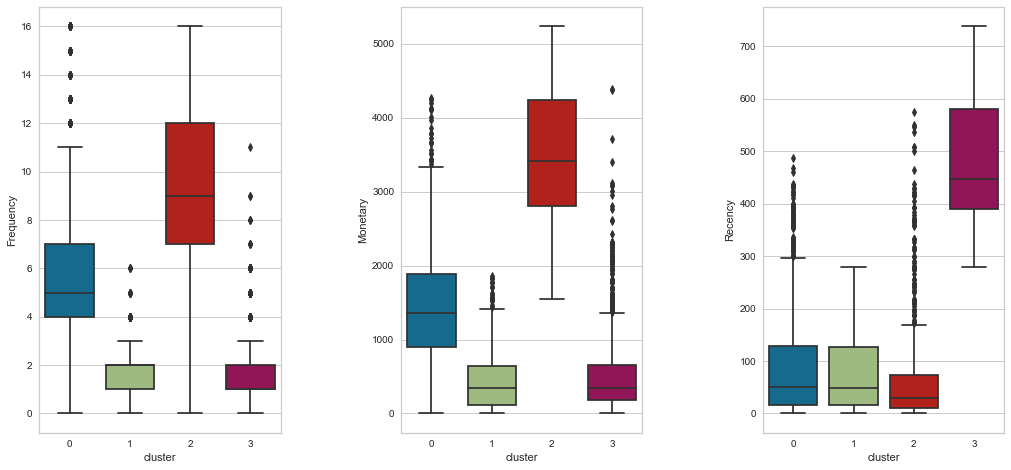

In [ ]:
create_boxplot(rfm_df_copy)

## Evaluation <a id='7'></a> 

In [ ]:
evaluation_df

,Clustering,silhouette_score,best_cluster_size,cluster_size,labeled_data
0,K-Means,0.432,3.0,3.0,Recency Frequency Monetary clu...
1,K-Means,0.421,3.0,5.0,Recency Frequency Monetary clu...
2,Hierarchical Clustering,0.394,2.0,2.0,Recency Frequency Monetary clu...
3,Hierarchical Clustering,0.370,2.0,4.0,Recency Frequency Monetary clu...
4,Fuzzy Clustering,0.432,3.0,3.0,Recency Frequency Monetary clu...
5,Fuzzy Clustering,0.403,3.0,2.0,Recency Frequency Monetary clu...
6,Fuzzy Clustering,0.398,3.0,4.0,Recency Frequency Monetary clu...


#### Comparison Cluster size = 2

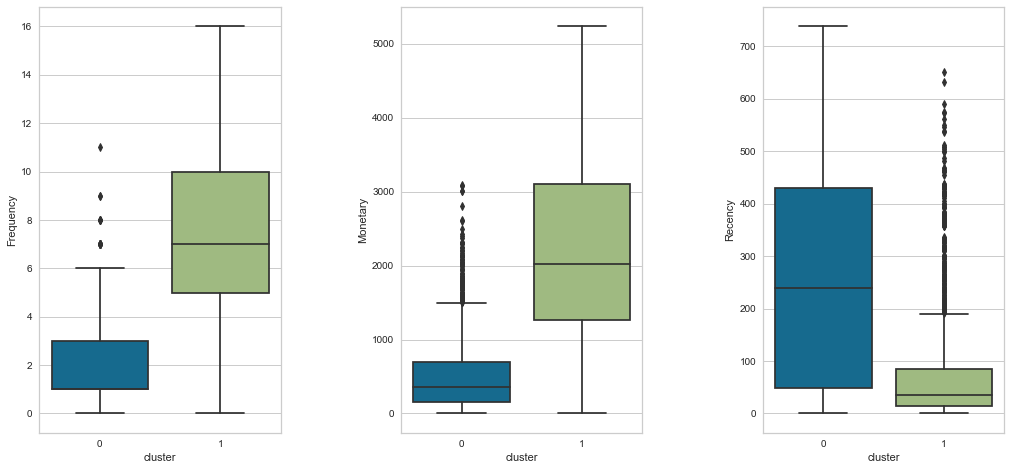

In [ ]:
# Hierarchical Clustering k=2
create_boxplot(pd.DataFrame(evaluation_df.iloc[2][4]))

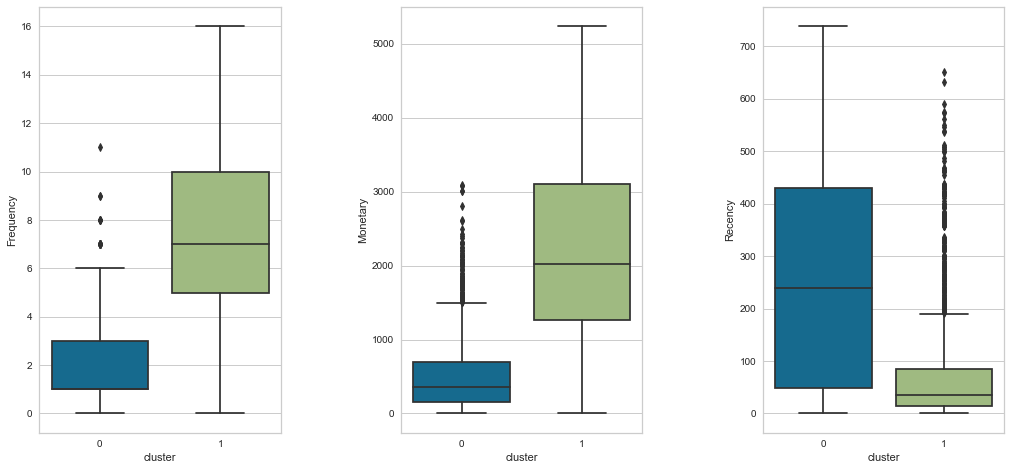

In [ ]:
# Fuzzy Clustering k=2
create_boxplot(pd.DataFrame(evaluation_df.iloc[5][4]))

#### Comparison Cluster size = 3

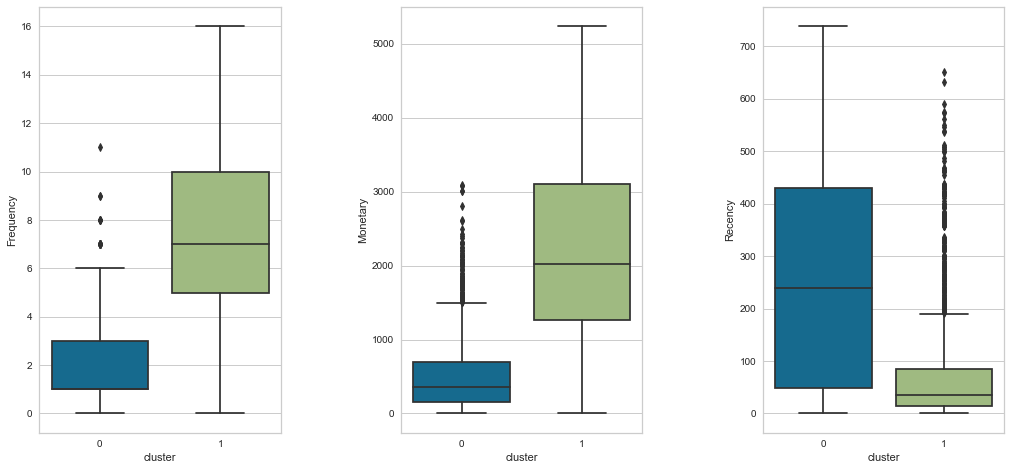

In [ ]:
# KMeans k=3
create_boxplot(pd.DataFrame(evaluation_df.iloc[0][4]))

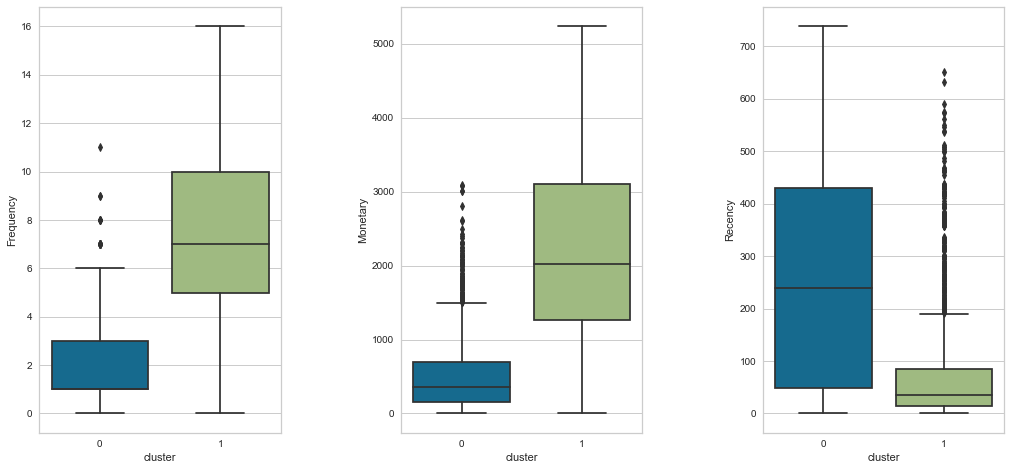

In [ ]:
# Fuzzy Clsutering k=3
create_boxplot(pd.DataFrame(evaluation_df.iloc[4][4]))

#### Comparison Cluster size = 4

In [ ]:
# Hierarchical Clustering k=4
create_boxplot(pd.DataFrame(evaluation_df.iloc[3][4]))

In [ ]:
# Fuzzy Clsutering k=4
create_boxplot(pd.DataFrame(evaluation_df.iloc[6][4]))

#### Comparison Cluster size = 5

In [ ]:
# KMeans k=5
create_boxplot(pd.DataFrame(evaluation_df.iloc[1][4]))